In [1]:
import os
import pandas as pd
import numpy as np
import mygene
import gseapy as gp
import gseapy.plot as gseaplot
import matplotlib.pyplot as plt

from gseapy import enrichment_map
import networkx as nx

# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

from gseapy import Biomart
bm = Biomart()

from gseapy import gseaplot, heatmap

In [2]:
#! pip install gseapy

In [13]:
def get_top_ranked_genes(DEG):
    Calu3_24h_DEGs = pd.read_csv(DEG, sep=',')

    Calu3_24h_DEGs['log2FoldChange'] = np.log2(Calu3_24h_DEGs['norm_foldChange']) 

    Calu3_24h_DEGs = Calu3_24h_DEGs[(Calu3_24h_DEGs['pvalue.adj.FDR'] < 0.05) & (Calu3_24h_DEGs['log2FoldChange'].abs() > 0.5)]
    Calu3_24h_DEGs['Rank'] = np.log10(Calu3_24h_DEGs['chi2LR1'])*Calu3_24h_DEGs.log2FoldChange

    Calu3_24h_DEGs = Calu3_24h_DEGs.sort_values('Rank', key= abs, ascending=False)

    ranking = Calu3_24h_DEGs['Rank']

    ranking = pd.DataFrame(ranking)

    # Annotate gene symbols using mygene package
    mg = mygene.MyGeneInfo()
    geneSyms = mg.querymany(ranking.index, scopes='ensembl.gene')

    df = pd.DataFrame(geneSyms)  # Convert annotation of genes into readable format

    df = df.set_index('query')

    df['rank'] = ranking['Rank']
    
    return  df[['symbol','rank']].dropna(subset=['symbol'])
                                                

In [15]:
def enrich_genes(top_ranked_genes):

    enr_Reactome_up = gp.enrichr(gene_list=top_ranked_genes,
                                 gene_sets=['Reactome_2022'],
                                 organism='Human', 
                                 cutoff=0.5)
    
    enr_GOBP_up = gp.enrichr(gene_list=top_ranked_genes,
                             gene_sets=['GO_Biological_Process_2021'],
                             organism='Human', 
                             cutoff=0.5)
    
    enr_GOMF_up = gp.enrichr(gene_list=top_ranked_genes ,
                             gene_sets=['GO_Molecular_Function_2021'],
                             organism='Human', 
                             cutoff=0.5)
    
    
    # Write results to CSV files
    #file_name = os.path.basename(file_path).split('.')[0]
    #enr_Reactome_up.results.to_csv(f'{file_name}_enr_Reactome.csv')
    
    return enr_Reactome_up.results, enr_GOBP_up.results, enr_GOMF_up.results

In [29]:
DEG8 = 'desingle_calu3_8h.csv'
DEG_8 = get_top_ranked_genes(DEG8)

DEG12 = 'desingle_calu3_12h.csv'
DEG_12 = get_top_ranked_genes(DEG12)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4858...done.
Finished.
5 input query terms found no hit:
	['ENSG00000204092', 'ENSG00000225178', 'ENSG00000215271', 'ENSG00000189144', 'ENSG00000273888']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-11806...done.
Finished.
16 input query terms found no hit:
	['ENSG00000256045', 'ENSG00000270672', 'ENSG00000256618', 'ENSG00000255823', 'ENSG00000271043', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [18]:
enr_Reactome_up, enr_GOBP_up, enr_GOMF_up = enrich_genes(DEG_8)

In [30]:
preprocessed_data = {} 
preprocessed_data['desingle_calu3_8h'] = DEG_8
preprocessed_data['desingle_calu3_12h'] = DEG_12

preprocessed_data['desingle_calu3_12h']

,symbol,rank
query,,
ENSG00000257660,ADCY6-DT,-inf
ENSG00000181143,MUC16,-inf
ENSG00000167207,NOD2,-inf
ENSG00000178732,GP5,-inf
ENSG00000205364,MT1M,-inf


In [42]:
preprocessed_data['desingle_calu3_12h']

,symbol,rank
query,,
ENSG00000257660,ADCY6-DT,-inf
ENSG00000181143,MUC16,-inf
ENSG00000167207,NOD2,-inf
ENSG00000178732,GP5,-inf
ENSG00000205364,MT1M,-inf
...,...,...
ENSG00000186765,FSCN2,0.520382
ENSG00000241313,WWTR1-AS1,-0.509156
ENSG00000245105,A2M-AS1,-0.502669


In [31]:
def prerank(df):
    pre_res = gp.prerank(rnk=df, # or rnk = rnk,
                         gene_sets='Reactome_2022',
                         threads=4,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000, # reduce number to speed up testing
                         outdir=None, # don't write to disk
                         seed=6,
                         verbose=True, # see what's going on behind the scenes
                        )
    return pre_res

In [32]:
pre_res = prerank(preprocessed_data['desingle_calu3_8h'])
pre_res2 =  prerank(preprocessed_data['desingle_calu3_12h'])

2023-05-01 23:44:39,221 [INFO] Parsing data files for GSEA.............................
2023-05-01 23:44:39,222 [INFO] Enrichr library gene sets already downloaded in: /Users/sofialuk/.cache/gseapy, use local file
2023-05-01 23:44:39,263 [INFO] 0751 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-05-01 23:44:39,263 [INFO] 1067 gene_sets used for further statistical testing.....
2023-05-01 23:44:39,264 [INFO] Start to run GSEA...Might take a while..................
2023-05-01 23:44:45,130 [INFO] Congratulations. GSEApy runs successfully................

2023-05-01 23:44:45,137 [WARNING] Input gene rankings contains inf values!
2023-05-01 23:44:45,138 [WARNING] Duplicated values found in preranked stats: 1.37% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-05-01 23:44:45,138 [INFO] Parsing data files for GSEA.............................
2023-05-01 23:44:45,138 [INFO] Enrichr library gene sets already downloaded in:

2023-05-02 00:10:56,370 [INFO] Parsing data files for GSEA.............................
2023-05-02 00:10:56,371 [INFO] Enrichr library gene sets already downloaded in: /Users/sofialuk/.cache/gseapy, use local file
2023-05-02 00:10:56,400 [INFO] 0751 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-05-02 00:10:56,400 [INFO] 1067 gene_sets used for further statistical testing.....
2023-05-02 00:10:56,400 [INFO] Start to run GSEA...Might take a while..................
2023-05-02 00:11:02,568 [INFO] Congratulations. GSEApy runs successfully................

2023-05-02 00:11:02,616 [INFO] Parsing data files for GSEA.............................
2023-05-02 00:11:02,617 [INFO] Enrichr library gene sets already downloaded in: /Users/sofialuk/.cache/gseapy, use local file
2023-05-02 00:11:02,642 [INFO] 0751 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-05-02 00:11:02,642 [INFO] 1067 gene_sets used for further statistical testing.....
2023-05-02 0

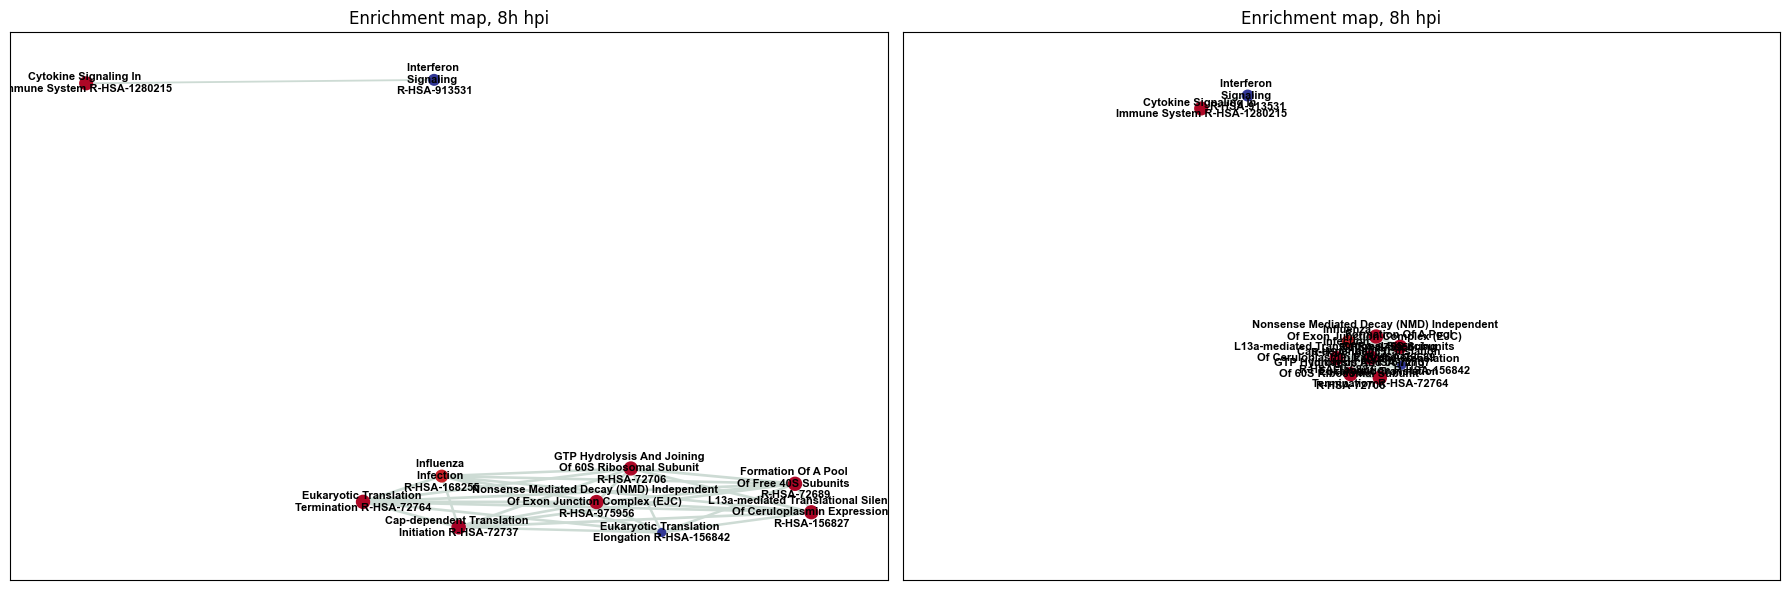

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # create a figure with 3 subplots

for i, (timepoint, ax) in enumerate(zip(['desingle_calu3_8h', 'desingle_calu3_8h'], axs)):
    pre_res = prerank(preprocessed_data[timepoint]).res2d  # run prerank for each timepoint

    nodes, edges = enrichment_map(pre_res, cutoff=0.5)

    G = nx.from_pandas_edgelist(edges,
                                source='src_idx',
                                target='targ_idx',
                                edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

    # init node cooridnates
    pos = nx.layout.spring_layout(G, k=1, iterations=100)
    # set node size
    node_size = nodes.Hits_ratio * 100
    
    # draw node
    nx.draw_networkx_nodes(G,
                           pos=pos,
                           cmap=plt.cm.RdYlBu,
                           node_color=list(nodes.NES),
                           node_size=node_size,
                           ax=ax)
    # split node label into multiple lines
    labels_dict = {}
    for k, v in nodes.Term.items():
        words = v.split(' ')
        n_words = len(words)
        if n_words <= 2:
            label = v
        else:
            label = ''
            for i, word in enumerate(words):
                if i != 0 and i % (n_words // 2) == 0:
                    label += '\n'
                label += word + ' '
        labels_dict[k] = label.strip()
    # draw node label
    nx.draw_networkx_labels(G,
                            pos=pos,
                            labels=labels_dict,
                            font_size=8,
                            font_weight='bold',
                            font_family='Arial',
                            verticalalignment='center',
                            horizontalalignment='center',
                            ax=ax)
    # draw edge
    edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
    nx.draw_networkx_edges(G,
                           pos=pos,
                           width=list(map(lambda x: x*10, edge_weight)),
                           edge_color='#CDDBD4',
                           ax=ax)
    # set subplot title
    ax.set_title(f"Enrichment map, {timepoint.split('_')[2]} hpi")

# set figure borders
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
plt.tight_layout()

# save figure
plt.savefig('calu3_enrichment_maps.png', dpi=300)
plt.show()

